##### Master Degree in Computer Science and Data Science for Economics

# Classification by RNN

### Alfio Ferrara

You can also see the [Tutorial PyTorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial).

## Data preparation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os

%cd /content/
!ls -R
repo_name = "NLP_COURSE"
#!rm -rf {repo_name}
if not os.path.exists(repo_name):
    print(f"Directory {repo_name} does not exist, proceeding with clone.")
    !git clone https://github.com/Abudo-S/NLP_COURSE.git

%cd NLP_COURSE

/content
.:
NLP_COURSE  sample_data

./NLP_COURSE:
data  imgs  lectures  nlp  projects  README.md	references

./NLP_COURSE/data:
biased-cv-doc.xlsx    README.md
biased-cv-tab.xlsx    recipes_w_search_terms.csv
food_recipes.csv      roman_number-classification.csv
get-movie-data.ipynb  roman_number-classification-test.csv
get-recipes.ipynb     roman_number-prediction.csv
moviedata.py	      roman_number-prediction-test.csv
political-bias.ipynb  weather.json

./NLP_COURSE/imgs:
clip.png	 image-acquisition.png	 raccoon.jpg
convolution.gif  image-generation.png	 stablediffusion.png
cv-tasks.png	 lenet.jpeg		 stride.png
depth.png	 mllm.png		 vit.gif
diffusion.png	 perceptron-example.jpg  vit.png
ffn-example.jpg  perceptron.jpg		 zero-padding.png
ffn.jpg		 pooling.png

./NLP_COURSE/lectures:
 CRFs.pdf		       P1-3-evaluation.pdf
 HMMs.pdf		       P1-4-relevance_feedback.pdf
 L00-course-introduction.pdf   P1-5-topic_modeling.pdf
'Language Modeling.pdf'        P1-6-unsupervised_classification.p

In [16]:
folder = '/content/NLP_COURSE'
classification_path = '{}/data/roman_number-classification.csv'.format(folder)
data = pd.read_csv(classification_path)

In [17]:
data.head(2)

,sequence,target
0,___CXXXIII,odd
1,____CXCVII,odd


We build a dictionary `{'category': [list of numbers]}`

As categories, we split the numbers between first and second half of the decade

In [18]:
#!pwd
!pip install roman-arabic-numerals
from roman_arabic_numerals import conv

def get_label(num):
    #print(conv.rom_arab(num))
    k = int(str(conv.rom_arab(num))[-1])
    if k < 5:
        return 'first'
    else:
        return 'second'

In [19]:
get_label('IV')

'first'

In [20]:
sequences = data.sequence.values
targets = data.target.values
vocabulary = set()
category_lines = {'first': [], 'second': []}
for i, seq in enumerate(sequences):
    n = seq.replace('_', '')
    for c in n:
        vocabulary.add(c)
    category_lines[get_label(n)].append(n)
vocabulary = sorted(list(vocabulary))
categories = list(category_lines.keys())

In [21]:
vocabulary

['C', 'I', 'L', 'V', 'X']

## Convert numbers in tensors
Each character is represented using *One-Hot encoding*: Each word in a vocabulary is represented as a binary vector where a single element is '1' and all others are '0'.
Distadvantages of one-hot-encoding:  
- High Dimensionality: The biggest problem is the size of the vectors. For a large vocabulary (e.g., 50,000 words), each vector will have 50,000 dimensions, with only one non-zero element. This makes the data very sparse and computationally inefficient.  
- No Semantic Relationship: One-hot encoding treats every word as completely independent. The vectors for "king" and "queen" are just as different as the vectors for "king" and "banana." The model learns nothing about the semantic relationships between words, which is a major limitation for many NLP tasks.  
- Curse of Dimensionality: In a high-dimensional space, the data becomes very sparse, making it difficult for models to find meaningful patterns.  

Due to these limitations, it has largely been replaced by more advanced techniques like word embeddings (e.g., Word2Vec, GloVe), which represent words as dense vectors in a lower-dimensional space while capturing their semantic relationships.  

Turn a line into a `<line_length x 1 x n_letters>`

In [22]:
import torch

In [23]:
def num2tensor(num):
    tensor = torch.zeros(len(num), 1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[li][0][vocabulary.index(letter)] = 1
    return tensor

In [24]:
num2tensor('XII')

tensor([[[0., 0., 0., 0., 1.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]]])

## RNN from scratch

In [25]:
#!pwd
%cd nlp/nlp
import neurnets as nt

/content/NLP_COURSE/nlp/nlp


In [26]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
rnn = nt.RNN(input_size, n_hidden, output_size)
rnn
#Negative Log-Likelihood Loss (NLLLoss) is a loss function that takes the negative logarithm
# of the predicted probability for the correct class.
# It expects its input to be log-probabilities, which are the results of a LogSoftmax function.

#Cross-Entropy is a single, convenient function that combines the LogSoftmax
# operation and NLLLoss. It takes the raw logits from the model's final layer directly.
#This is mathematically equivalent to applying LogSoftmax to the logits and then computing NLLLoss.

RNN(
  (i2h): Linear(in_features=5, out_features=32, bias=True)
  (h2h): Linear(in_features=32, out_features=32, bias=True)
  (h2o): Linear(in_features=32, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)

### Prediction with no training

In [27]:
input_example = num2tensor('IX')
print(input_example)
hidden_example = torch.zeros(1, n_hidden)
with torch.no_grad():
    output, next_hidden = rnn(input_example[0], hidden_example)
    print(output)
    print(next_hidden)

tensor([[[0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 1.]]])
tensor([[-0.6111, -0.7826]])
tensor([[-0.2725, -0.1863,  0.6643, -0.0584,  0.0082, -0.1465,  0.2955, -0.4581,
          0.4427, -0.3081, -0.0356,  0.4910, -0.3144, -0.0087,  0.1286,  0.1640,
          0.5579, -0.4629, -0.6023,  0.4662, -0.0021, -0.1019, -0.4456, -0.2930,
         -0.1921, -0.2563,  0.1874,  0.6458,  0.1855,  0.1095, -0.2180, -0.0855]])


## Training

In [28]:
import torch.nn as nn

### Utility functions

In [29]:
def read_categories(output):
    top_n, top_i = output.topk(1)
    print(top_n, top_i)
    category_i = top_i[0].item()
    return categories[category_i], category_i

print(read_categories(output))

tensor([[-0.6111]]) tensor([[0]])
('first', 0)


Random construction of a training set:

In [30]:
def random_training_sample(embedding_function: callable):
    category = np.random.choice(categories)
    line = np.random.choice(category_lines[category])
    category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
    line_tensor = embedding_function(line)
    return category, line, category_tensor, line_tensor

In [31]:
for i in range(6):
    c, n, _, _ = random_training_sample(num2tensor)
    print(n, c)

XIII first
LXXVI second
LXVII second
CCVII second
CLXXVI second
CXL first


In [32]:
print(vocabulary)

['C', 'I', 'L', 'V', 'X']


## Training and error plot

In [66]:
input_size = len(vocabulary)
n_hidden = 16
output_size = len(categories)
rnn = nt.RNN(input_size, n_hidden, output_size)

In [71]:
n_iterations = 10000
plot_every = 100
history = rnn.run_training(data_generator=random_training_sample, embedding_function=num2tensor,
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:14<00:00, 682.63it/s]


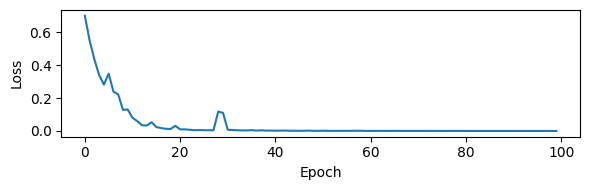

In [72]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.tight_layout()
plt.show()

## Evaluation

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [37]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = rnn.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

tensor([[-6.7949e-06]]) tensor([[0]])
tensor([[-2.1696e-05]]) tensor([[0]])
tensor([[-0.0001]]) tensor([[0]])
tensor([[-0.0001]]) tensor([[1]])
tensor([[0.]]) tensor([[0]])
tensor([[-4.0531e-06]]) tensor([[1]])
tensor([[-1.0729e-06]]) tensor([[1]])
tensor([[-2.0742e-05]]) tensor([[0]])
tensor([[-5.6028e-06]]) tensor([[0]])
tensor([[-0.0001]]) tensor([[1]])
tensor([[-1.3947e-05]]) tensor([[0]])
tensor([[0.]]) tensor([[0]])
tensor([[-3.9339e-06]]) tensor([[1]])
tensor([[-2.5034e-06]]) tensor([[0]])
tensor([[-1.7881e-06]]) tensor([[1]])
tensor([[-8.7019e-05]]) tensor([[1]])
tensor([[-2.7418e-06]]) tensor([[0]])
tensor([[-2.6226e-06]]) tensor([[0]])
tensor([[-2.4199e-05]]) tensor([[0]])
tensor([[-1.0610e-05]]) tensor([[0]])
tensor([[-0.0001]]) tensor([[1]])
tensor([[-4.0531e-06]]) tensor([[1]])
tensor([[-3.2186e-05]]) tensor([[0]])
tensor([[-7.9867e-05]]) tensor([[0]])
tensor([[-3.3379e-06]]) tensor([[1]])
tensor([[-2.3842e-06]]) tensor([[0]])
tensor([[-2.0266e-06]]) tensor([[1]])
tensor([

In [60]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       first       0.61      0.27      0.37       507
      second       0.52      0.82      0.64       493

    accuracy                           0.54      1000
   macro avg       0.56      0.54      0.50      1000
weighted avg       0.56      0.54      0.50      1000



### Comparison with BOW
Let's create a neural network that maps a BOW (One-Hot) representation of the sequence as a whole into a classes vector. Let's also use a hidden layer.

In [61]:
def num2bow(num):
    tensor = torch.zeros(1, len(vocabulary))
    for li, letter in enumerate(num):
        tensor[0][vocabulary.index(letter)] += 1
    return tensor

In [40]:
input_dim = len(vocabulary)
hidden_dim = 16
output_dim = len(categories)
learning_rate = 0.005
bow = nt.FrequencyPredictor(input_dim, hidden_dim, output_dim)
bow
#the first layer that processes the raw input is implicitly considered the input layer. (in our case it's the hidden layer)

FrequencyPredictor(
  (hidden_layer): Linear(in_features=5, out_features=16, bias=True)
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (activation): ReLU()
  (softmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)

### Training

In [67]:
n_iterations = 10000
plot_every = 100
history = bow.run_training(data_generator=random_training_sample, embedding_function=num2bow,
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:08<00:00, 1196.21it/s]


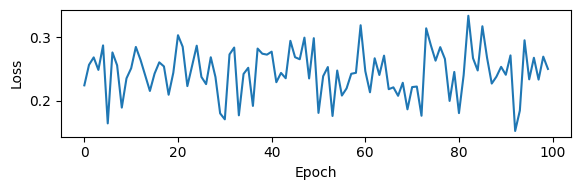

In [69]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.tight_layout()
plt.show()

In [43]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2bow)
    output = bow.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

tensor([[-0.0543]]) tensor([[1]])
tensor([[-0.2185]]) tensor([[0]])
tensor([[-0.4482]]) tensor([[0]])
tensor([[-6.8305e-05]]) tensor([[0]])
tensor([[-0.0002]]) tensor([[0]])
tensor([[-0.5724]]) tensor([[0]])
tensor([[-0.4482]]) tensor([[0]])
tensor([[-0.0006]]) tensor([[1]])
tensor([[-0.0018]]) tensor([[0]])
tensor([[-0.3242]]) tensor([[0]])
tensor([[-0.5724]]) tensor([[0]])
tensor([[-2.7299e-05]]) tensor([[0]])
tensor([[-0.0048]]) tensor([[1]])
tensor([[-0.0431]]) tensor([[1]])
tensor([[-0.0002]]) tensor([[1]])
tensor([[-3.2186e-06]]) tensor([[0]])
tensor([[-0.5547]]) tensor([[0]])
tensor([[-0.0002]]) tensor([[1]])
tensor([[-5.6623e-05]]) tensor([[0]])
tensor([[-0.2213]]) tensor([[0]])
tensor([[-0.5061]]) tensor([[0]])
tensor([[-0.0001]]) tensor([[1]])
tensor([[-0.0543]]) tensor([[1]])
tensor([[-1.1921e-07]]) tensor([[0]])
tensor([[-0.0013]]) tensor([[0]])
tensor([[-0.2185]]) tensor([[0]])
tensor([[-0.2752]]) tensor([[0]])
tensor([[-0.0005]]) tensor([[0]])
tensor([[-0.0001]]) tensor([

In [44]:
print(classification_report(y_true, y_pred, zero_division=0))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

       first       0.80      0.94      0.86       502
      second       0.93      0.76      0.84       498

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000

[[474  28]
 [120 378]]


## Fake RNN
This network is identical to the RNN but it does not propagate the information in the hidden layer to the final layer.  
The key difference is in forward(), the current hidden state doesn't consider the last one: F.tanh(self.i2h(input)), meanwhile in RNN: F.tanh(self.i2h(input) + self.h2h(hidden)). FakeNN would have lower performance on sequential data.

In [45]:
input_size = len(vocabulary)
n_hidden = 32
output_size = len(categories)
fake = nt.FakeRNN(input_size, n_hidden, output_size)

In [46]:
input_example = num2tensor('IX')
hidden_example = torch.zeros(1, n_hidden)
with torch.no_grad():
    output, next_hidden = fake(input_example[0], hidden_example)
    print(output)

tensor([[-0.6343, -0.7557]])


In [47]:
n_iterations = 10000
plot_every = 100
history = fake.run_training(data_generator=random_training_sample, embedding_function=num2tensor,
                        n_iterations=n_iterations, plot_every=plot_every)

100%|██████████| 10000/10000 [00:10<00:00, 943.04it/s]


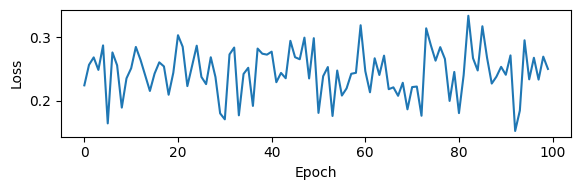

In [70]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(history)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.tight_layout()
plt.show()

### Valutazione

In [49]:
n_test = 1000
y_true, y_pred = [], []
for i in range(n_test):
    category, line, category_tensor, line_tensor = random_training_sample(num2tensor)
    output = fake.predict(line_tensor)
    predicted_label, predicted_index = read_categories(output)
    y_true.append(str(category))
    y_pred.append(str(predicted_label))
print(y_true[:3], y_pred[:3])

tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.0484]]) tensor([[0]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.4156]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.6637]]) tensor([[0]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.5418]]) tensor([[1]])
tensor([[-0.54

In [50]:
print(classification_report(y_true, y_pred, zero_division=0))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

       first       0.61      0.27      0.37       507
      second       0.52      0.82      0.64       493

    accuracy                           0.54      1000
   macro avg       0.56      0.54      0.50      1000
weighted avg       0.56      0.54      0.50      1000

[[135 372]
 [ 88 405]]


## Example

In [51]:
example = ['VI', 'IV']
models = [(num2tensor, rnn, 'RNN'), (num2bow, bow, 'BOW'), (num2tensor, fake, 'FAKE')]
for n in example:
    for f, m, name in models:
        output = m.predict(f(n))
        c, i = read_categories(output=output)
        print(name, n, c)

tensor([[-8.3446e-07]]) tensor([[1]])
RNN VI second
tensor([[-0.4443]]) tensor([[1]])
BOW VI second
tensor([[-0.5418]]) tensor([[1]])
FAKE VI second
tensor([[-0.0002]]) tensor([[0]])
RNN IV first
tensor([[-0.4443]]) tensor([[1]])
BOW IV second
tensor([[-0.6637]]) tensor([[0]])
FAKE IV first


In [52]:
print("BOW")
with torch.no_grad():
    print(np.exp(bow(num2bow('VI')).numpy()))
    print(np.exp(bow(num2bow('IV')).numpy()))

print("\nFAKE")
with torch.no_grad():
    print(np.exp(fake.predict(num2tensor('X')).numpy()))
    print(np.exp(fake.predict(num2tensor('IX')).numpy()))

print("\nRNN")
with torch.no_grad():
    print(np.exp(rnn.predict(num2tensor('VI')).numpy()))
    print(np.exp(rnn.predict(num2tensor('IV')).numpy()))

BOW
[[0.35874483 0.6412552 ]]
[[0.35874483 0.6412552 ]]

FAKE
[[0.34002617 0.6599738 ]]
[[0.34002617 0.6599738 ]]

RNN
[[8.1688307e-07 9.9999917e-01]]
[[9.9981713e-01 1.8280788e-04]]
